In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import shutil
import pickle

from utils.fmri_signal_extract import signal_extract
from utils.matrix_harmonization import corr_matrix_harmonization
from utils.sliding_window_fc import dynamic_functional_connectivity


from nilearn import datasets
from nilearn import plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.maskers import NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/datasets/struct.py:378: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  warnings.warn("Default resolution of the MNI template will change "


# Dataset with demographics and img paths

In [25]:
df = pd.read_excel('/media/gruneco-server/DB_GRUNECO/reporte_blind_biomarcadores.xls')
df = df[~df['rs_fmri'].isna()]
df.head()

,Id intranet,Documento,Nombre completo,Escolaridad,Sexo,Fecha de nacimiento,Edad,Superviviencia,Fecha de muerta,Pais de nacimiento,...,EPS,Edad inicio DCL,Edad inicio Demencia,Codes,último Minimental,Fecha último Minimental,último Fast,Fecha último Fast,Group E280A,rs_fmri
1,4030,1017218345,Ana Maria Betancur Zapata,15,Femenino,1994-04-18,28,Vivo,,Colombia,...,SANITAS E.P.S. S.A.,,,SAN_003,30.0,2021-09-15,1.0,2021-09-15,GK,dswausub-GK-003-S69500_task-rest_run1_FE_EPI_R...
7,25462,1152702477,Jennyfer Natalia Perez Balbin,13,Femenino,1996-02-01,26,Vivo,,Colombia,...,SUSALUD S.A. COMPAÑIA SURAMERICANA DE SERVICIO...,,,SAN_005,30.0,2021-09-14,1.0,2021-09-14,GK,dswausub-GK-005-S69440_task-rest_run1_FE_EPI_r...
8,14193,1020433358,Jessica Yesenia Cardenas Londoño,11,Femenino,1990-07-25,32,Vivo,,Colombia,...,SUSALUD S.A. COMPAÑIA SURAMERICANA DE SERVICIO...,,,SAN_006,30.0,2020-12-14,1.0,2020-12-14,GK,dswauGK-006_task-rest-1_run-01_bold_2023012811...
10,25575,1216724582,Juliana Betancur Zapata,16,Femenino,1997-08-16,25,Vivo,,Colombia,...,SURA E.P.S.,,,SAN_009,30.0,2020-12-10,1.0,2020-12-10,GK,dswauGK-009_task-rest-1_run-01_bold_2023020215...
13,1621,1214734589,Juan Esteban Barrera Cuartas,9,Masculino,1995-12-01,27,Vivo,,Colombia,...,SALUD TOTAL S.A. E.P.S.,,,SAN_021,30.0,2020-12-16,1.0,2020-12-16,GW,dswauGW-021_task-rest-1_run-01_bold_2023020213...


# Load mask

## gICA 300ROI Atlas

In [54]:
# all mask by group, each mask has 15 nets (300ROI Seitzman + PMN)

masker_GICA_300ROI = dict([('GK_BIOMARCADORES', '/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GK/nets_GK_BIOMARCADORES.nii'),
                           ('GW_BIOMARCADORES', '/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GW/nets_GW_BIOMARCADORES.nii')])

## Yeo, Schaefer and Seitzman atlas

Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located at: /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz


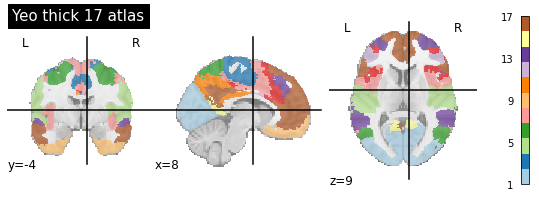

In [37]:
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
print('Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located '
      'at: %s' % atlas_yeo_2011.thick_17)

plotting.plot_roi(atlas_yeo_2011.thick_17, title='Yeo thick 17 atlas',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired'
                  #, output_file='Yeo_thick_17_atlas.png'
                  )

Schaefer atlas nifti image (3D) with 17 parcels and liberal mask is located at: /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz


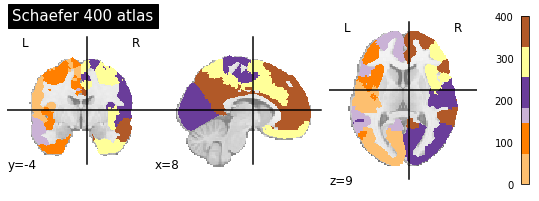

In [38]:
atlas_schaefer_2018 = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1)
# Prepend background label
atlas_schaefer_2018.labels = np.insert(atlas_schaefer_2018.labels, 0, 'Background')
print('Schaefer atlas nifti image (3D) with 17 parcels and liberal mask is located '
      'at: %s' % atlas_schaefer_2018.maps)
plotting.plot_stat_map(atlas_schaefer_2018.maps, title='Schaefer 400 atlas',
                  cut_coords=(8, -4, 9), vmax=400, cbar_tick_format='%i', colorbar=True, cmap='Paired'
                  #, output_file='Schaefer_400_atlas.png'
                    )

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/datasets/atlas.py:1372: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))


Seitzman atlas comes with dict_keys(['rois', 'radius', 'networks', 'regions', 'description']).
Stacked power coordinates in array of shape (300, 3).


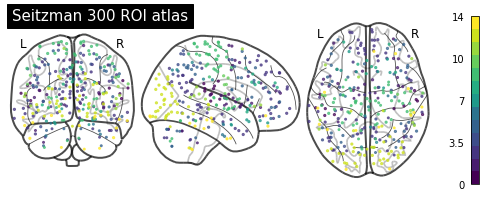

In [39]:
atlas_seitzman_300roi = datasets.fetch_coords_seitzman_2018()

print('Seitzman atlas comes with {0}.'.format(atlas_seitzman_300roi.keys()))

atlas_seitzman_300roi_coords = np.vstack((atlas_seitzman_300roi.rois['x'], atlas_seitzman_300roi.rois['y'], atlas_seitzman_300roi.rois['z'])).T

print('Stacked power coordinates in array of shape {0}.'.format(atlas_seitzman_300roi_coords.shape))

from matplotlib.colors import ListedColormap
flat = np.column_stack(np.apply_along_axis(np.unique, 0, atlas_seitzman_300roi.networks, return_inverse=True)[1])
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(set(atlas_seitzman_300roi.networks))))
newcmp = ListedColormap(colors)


plotting.plot_markers(node_values=flat, node_size=atlas_seitzman_300roi.radius,
                      node_coords=atlas_seitzman_300roi_coords,  title='Seitzman 300 ROI atlas', node_vmin=0, node_vmax=len(newcmp.colors), node_cmap=newcmp, colorbar=True
                     #, output_file='SSeitzman_300_ROI_atlas.png'
                      )

# Images directories

In [55]:
# subjects
df_GK = df.loc[df['Group E280A'] == 'GK']
df_GW = df.loc[df['Group E280A'] == 'GW']

# Group Path
path_GK_BIOMARCADORES = '/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/GK/'
path_GW_BIOMARCADORES = '/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/GW/'

In [41]:
df_GW.head()

,Id intranet,Documento,Nombre completo,Escolaridad,Sexo,Fecha de nacimiento,Edad,Superviviencia,Fecha de muerta,Pais de nacimiento,...,EPS,Edad inicio DCL,Edad inicio Demencia,Codes,último Minimental,Fecha último Minimental,último Fast,Fecha último Fast,Group E280A,rs_fmri
13,1621,1214734589,Juan Esteban Barrera Cuartas,9,Masculino,1995-12-01,27,Vivo,,Colombia,...,SALUD TOTAL S.A. E.P.S.,,,SAN_021,30.0,2020-12-16,1.0,2020-12-16,GW,dswauGW-021_task-rest-1_run-01_bold_2023020213...
14,18609,1042768281,Andrey Felipe López López,5,Masculino,1990-08-29,32,Vivo,,Colombia,...,SALUD TOTAL S.A. E.P.S.,,,SAN_004,29.0,2020-12-23,2.0,2020-12-23,GW,dswausub-GW-004-S72620_task-rest_run1_FE_EPI_R...
16,4484,1037617635,Leidi Baneza Cardenas García,13,Femenino,1991-09-28,31,Vivo,,Colombia,...,SURA E.P.S.,,,SAN_015,27.0,2021-09-14,1.0,2021-09-14,GW,dswausub-GW-015-S69510_task-rest_run1_FE_EPI_R...
25,1302,1039454160,Alejandra Sepúlveda Martínez,13,Femenino,1990-10-27,32,Vivo,,Colombia,...,NUEVA E.P.S.,,,SAN_034,30.0,2020-12-03,1.0,2020-12-03,GW,dswausub-GW-034_DICOM_task-rest_run1_FE_EPI_DI...
32,6049,1035429191,Isabel Cristina Valencia Calle,13,Femenino,1992-11-26,30,Vivo,,Colombia,...,SURA E.P.S.,,,SAN_024,30.0,2021-01-15,1.0,2021-01-15,GW,dswausub-GW-024-Export_task-rest_run1_FE_EPI_R...


## Transform Covariables to numeric

In [30]:
def cov_to_num(df_cov, cov, cat):
    from sklearn import preprocessing
    df_covars = df_cov[cov]
    df_covars[['le_SEXO']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)
    df_covars_num = df_covars.select_dtypes(include=np.number)
    return df_covars_num

covs = ['Sexo', 'Edad', 'último Minimental', 'último Fast', 'Escolaridad']
cat = ['Sexo']
df_GW_covars_num = cov_to_num(df_GW, covs, cat)
df_GK_covars_num = cov_to_num(df_GK, covs, cat)

/tmp/ipykernel_4494/1050516720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_4494/1050516720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)


## Group paths

In [56]:
df_GK['path'] = path_GK_BIOMARCADORES + df_GK.rs_fmri

df_GK.head()

/tmp/ipykernel_4494/1888029845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GK['path'] = path_GK_BIOMARCADORES + df_GK.rs_fmri


,Id intranet,Documento,Nombre completo,Escolaridad,Sexo,Fecha de nacimiento,Edad,Superviviencia,Fecha de muerta,Pais de nacimiento,...,Edad inicio DCL,Edad inicio Demencia,Codes,último Minimental,Fecha último Minimental,último Fast,Fecha último Fast,Group E280A,rs_fmri,path
1,4030,1017218345,Ana Maria Betancur Zapata,15,Femenino,1994-04-18,28,Vivo,,Colombia,...,,,SAN_003,30.0,2021-09-15,1.0,2021-09-15,GK,dswausub-GK-003-S69500_task-rest_run1_FE_EPI_R...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
7,25462,1152702477,Jennyfer Natalia Perez Balbin,13,Femenino,1996-02-01,26,Vivo,,Colombia,...,,,SAN_005,30.0,2021-09-14,1.0,2021-09-14,GK,dswausub-GK-005-S69440_task-rest_run1_FE_EPI_r...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
8,14193,1020433358,Jessica Yesenia Cardenas Londoño,11,Femenino,1990-07-25,32,Vivo,,Colombia,...,,,SAN_006,30.0,2020-12-14,1.0,2020-12-14,GK,dswauGK-006_task-rest-1_run-01_bold_2023012811...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
10,25575,1216724582,Juliana Betancur Zapata,16,Femenino,1997-08-16,25,Vivo,,Colombia,...,,,SAN_009,30.0,2020-12-10,1.0,2020-12-10,GK,dswauGK-009_task-rest-1_run-01_bold_2023020215...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
17,2352,1035434591,Estefania Oquendo Tamayo,16,Femenino,1995-12-17,27,Vivo,,Colombia,...,,,SAN_023,28.0,2021-02-02,1.0,2021-02-02,GK,dswausub-GK-023-S69550_task-rest_run1_FE_EPI_R...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...


In [57]:
df_GW['path'] = path_GW_BIOMARCADORES + df_GW.rs_fmri

df_GW.head()

/tmp/ipykernel_4494/2599716506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GW['path'] = path_GW_BIOMARCADORES + df_GW.rs_fmri


,Id intranet,Documento,Nombre completo,Escolaridad,Sexo,Fecha de nacimiento,Edad,Superviviencia,Fecha de muerta,Pais de nacimiento,...,Edad inicio DCL,Edad inicio Demencia,Codes,último Minimental,Fecha último Minimental,último Fast,Fecha último Fast,Group E280A,rs_fmri,path
13,1621,1214734589,Juan Esteban Barrera Cuartas,9,Masculino,1995-12-01,27,Vivo,,Colombia,...,,,SAN_021,30.0,2020-12-16,1.0,2020-12-16,GW,dswauGW-021_task-rest-1_run-01_bold_2023020213...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
14,18609,1042768281,Andrey Felipe López López,5,Masculino,1990-08-29,32,Vivo,,Colombia,...,,,SAN_004,29.0,2020-12-23,2.0,2020-12-23,GW,dswausub-GW-004-S72620_task-rest_run1_FE_EPI_R...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
16,4484,1037617635,Leidi Baneza Cardenas García,13,Femenino,1991-09-28,31,Vivo,,Colombia,...,,,SAN_015,27.0,2021-09-14,1.0,2021-09-14,GW,dswausub-GW-015-S69510_task-rest_run1_FE_EPI_R...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
25,1302,1039454160,Alejandra Sepúlveda Martínez,13,Femenino,1990-10-27,32,Vivo,,Colombia,...,,,SAN_034,30.0,2020-12-03,1.0,2020-12-03,GW,dswausub-GW-034_DICOM_task-rest_run1_FE_EPI_DI...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
32,6049,1035429191,Isabel Cristina Valencia Calle,13,Femenino,1992-11-26,30,Vivo,,Colombia,...,,,SAN_024,30.0,2021-01-15,1.0,2021-01-15,GW,dswausub-GW-024-Export_task-rest_run1_FE_EPI_R...,/media/gruneco-server/DB_GRUNECO/BIOMARCADORES...


In [58]:
subjects_GK_ts = df_GK.path
print(len(subjects_GK_ts))
subjects_GK_ts

18


1      /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
7      /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
8      /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
10     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
17     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
21     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
26     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
27     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
28     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
31     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
33     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
40     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
45     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
48     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
49     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
53     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
60     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
113    /media/gruneco-server/DB

In [59]:
subjects_GW_ts = df_GW.path
print(len(subjects_GW_ts))
subjects_GW_ts

13


13     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
14     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
16     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
25     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
32     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
41     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
42     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
44     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
54     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
57     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
65     /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
129    /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
134    /media/gruneco-server/DB_GRUNECO/BIOMARCADORES...
Name: path, dtype: object

In [103]:
print(subjects_GW_ts.iloc[12])

/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/GW/dswausub-GW-060-Export_task-rest_run1_FE_EPI_REPOSO_20221112100734_301_brain.nii


# Signal extract

## Static and Dynamic

In [104]:
mask = {
        'GICA_300ROI': {
                'type': 'Maps',
                'mask': masker_GICA_300ROI,
                'config': None},
        'yeo': {
                'type': 'Labels',
                'mask': atlas_yeo_2011.thick_17,
                'config': None},
        'schaefer': {
                'type': 'Labels',
                'mask': atlas_schaefer_2018.maps,
                'config': None},
        'seitzman_300ROI': {
                'type': 'Spheres',
                'mask': atlas_seitzman_300roi.rois,
                'config': {'radius': 5}}
        }
#metrics = ['partial correlation', 'correlation', 'covariance']
metrics = ['partial correlation']

subj_repo_ts = [subjects_GK_ts, subjects_GW_ts]

#subj_harm_ts = [subjects_AD_ts, subjects_CN_AD_ts, subjects_MCI_ts, subjects_CN_MCI_ts]

#
subj_group_config = {
        'GK_BIOMARCADORES': {
                'atlas': [mask.get('GICA_300ROI').get('mask').get('GK_BIOMARCADORES'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'GK',
                'tr': 2.2
                },
        'GW_BIOMARCADORES': {
                'atlas': [mask.get('GICA_300ROI').get('mask').get('GW_BIOMARCADORES'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'GW',
                'tr': 2.2
                }
        }


subj_group_config.keys()

dict_keys(['GK_BIOMARCADORES', 'GW_BIOMARCADORES'])

In [105]:
def extract_fc(subj, mask, mask_type, kind, fname, config: dict = {}, save_results=True):
    from numpy import savetxt
    import os
    import shutil
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    config = config if config is not None else {}
    fname = fname + f'/{kind.replace(" ", "_")}'
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    ts, roi_img, labels, masker_type = signal_extract(subj, mask, masker_type=mask_type, config=config)
    #print(ts)
    row=len(ts)
    column=len(ts[0])
    print(f'Rows:{row}, Column:{column}')
    print("Shape of a list (ts):",len(ts))
    connectome_measure = ConnectivityMeasure(kind=kind)
    correlation_matrices = connectome_measure.fit_transform(ts)
    mean_correlation_matrix = connectome_measure.mean_

    # correlation_matricesReshaped = correlation_matrices.reshape(correlation_matrices.shape[0], -1)
    # correlation_matricesReshaped.to_csv('/home/kevrodz/Documents/Master/scripts/connectome_measure_corr.csv', index=False)

    if save_results:
        # Create the folder
        if not os.path.exists(fname):
            os.makedirs(fname)
        else:
            shutil.rmtree(fname)  # Removes all the subdirectories
            os.makedirs(fname)
        # Save the conn matrix into their respective folder
        for i in range(correlation_matrices.shape[0]):
            savetxt(f'{fname}/subj_{i}_connectome_measure_{kind.replace(" ", "_")}.csv', correlation_matrices[i], delimiter=',')
        savetxt(f'{fname}/subj_all_connectome_measure_mean_{kind.replace(" ", "_")}.csv', mean_correlation_matrix, delimiter=',')
    #connectome_measure_cov = ConnectivityMeasure(kind='covariance')  # covariance
    #connectome_measure_pcorr = ConnectivityMeasure(kind='partial correlation')  # partial correlation
    return correlation_matrices, mean_correlation_matrix

def extract_dyn_fc(slwin_ts, kind):
    sw_ts = list()
    for w in range(slwin_ts.shape[1]): # n_window
        sw_ts = list()
        for subj in range(slwin_ts.shape[0]): # subject
            sw_ts.append(slwin_ts[subj][w])
    connectome_measure = ConnectivityMeasure(kind=kind)
    correlation_matrices = connectome_measure.fit_transform(sw_ts)
    mean_correlation_matrix = connectome_measure.mean_

    return correlation_matrices, mean_correlation_matrix

In [106]:
masker_GICA_300ROI

{'GK_BIOMARCADORES': '/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GK/nets_GK_BIOMARCADORES.nii',
 'GW_BIOMARCADORES': '/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GW/nets_GW_BIOMARCADORES.nii'}

In [ ]:
# Raw (no harmonization)
for idx, val in enumerate(subj_group_config.keys()):
    for idx_mask, mask_value in enumerate(mask.keys()):
        for idx_metric, metric_value in enumerate(metrics):
           print(val, mask_value, metric_value)
           correlation_matrices, mean_correlation_matrix = extract_fc(subj=subj_repo_ts[idx],
                                                                       mask=subj_group_config.get(val).get('atlas')[idx_mask],
                                                                       mask_type=subj_group_config.get(val).get('mask_type')[idx_mask],
                                                                       kind=metrics[idx_metric],
                                                                       fname=f'/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/functional_connectivity/static/FC_{val}/{mask_value}/{metric_value}/',
                                                                       config=mask.get(mask_value).get('config'),
                                                                       save_results=True)

In [108]:
ts_GK, corr_GK, mean_corr_GK, wl_dim_GK = [], [], [], []
ts_GW, corr_GW, mean_corr_GW, wl_dim_GW = [], [], [], []

ts_mask = {'GICA_300ROI': {},
           'yeo': {},
           'schaefer': {},
           'seitzman_300ROI': {}}

ts_group = {
        'GK': {'ts': [],
               'cov': df_GK,
               'cov_num': df_GK_covars_num,
               'corr_matrix': {},
               'corr': [],
               'mean_corr': [],
               'wl_dim': wl_dim_GK,
               'harmonization': False,
               'windows': {},
               'harm_corr': {}},
        'GW': {'ts': [],
               'cov': df_GW,
               'cov_num': df_GW_covars_num,
               'corr': [],
               'mean_corr': [],
               'wl_dim': wl_dim_GW,
               'harmonization': False,
               'windows': {},
               'harm_corr': {}}
        }

# TEST IMG
# subj_repo_ts = [subjects_AD_ADNI_ts[:9], subjects_CN_AD_ADNI_ts[:2], subjects_AD_OASIS_ts[:2],
#            subjects_CN_AD_OASIS_ts[:2], subjects_MCI_ts[:2], subjects_CN_MCI_ts[:2]]

In [109]:
def extract_harm_ts(subj, mask, mask_type, config: dict = {}):
    from numpy import savetxt
    import os
    import shutil
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    config = config if config is not None else {}
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    ts, roi_img, labels, masker_type = signal_extract(subj, mask, masker_type=mask_type, config=config)

    return ts, roi_img, labels, masker_type

In [85]:
subj_group_config.get('GK_BIOMARCADORES').get('tr')

2.2

In [110]:
# Dynamic (harmonization)

for idx_mask, mask_value in enumerate(mask.keys()):
    for idx_metric, metric_value in enumerate(metrics):
        wl_dim = list()
        n_slwin_flag = list()  # number of sliding window flag
        slwin_ts_list = []
        for idx, val in enumerate(subj_group_config.keys()):
            # Extract time series for each group by each mask
            #fname = f'/home/kevrodz/Documents/Master/functional_connectivity/dynamic/FC_{val}/{mask_value}/{metric_value.replace(" ", "_")}/'
            #fname = fname + f'{metrics[idx_metric].replace(" ", "_")}'
            ts, roi_img, labels, masker_type = extract_harm_ts(subj=subj_repo_ts[idx],
                                                               mask=subj_group_config.get(val).get('atlas')[idx_mask],
                                                               mask_type=subj_group_config.get(val).get('mask_type')[idx_mask],
                                                               config=mask.get(mask_value).get('config'))
            if subj_group_config.get(val).get('group') == 'GK':
                ts_group.get('GK').get('ts').extend(ts)
            elif subj_group_config.get(val).get('group') == 'GW':
                ts_group.get('GW').get('ts').extend(ts)
 

            print('_________________________________________________')
            print(val, mask_value)
            row = len(ts_group.get(subj_group_config.get(val).get('group')).get('ts'))
            column = len(ts_group.get(subj_group_config.get(val).get('group')).get('ts')[0])
            #print(f'{val} Rows:{row}, Column:{column}')
            #print("Shape of a list (ts): ", len(ts_group.get(subj_group_config.get(val).get('group')).get('ts')))
            print('__________________________________________________')
            #print(f'lenght ts (subjects): {len(ts)}')
            #np_ts = np.asarray(ts)

            #wl = round(column / ((subj_group_config.get(val).get('tr') * column) / 60))  # window length in vols (60 seconds)
            # window length in vols
            wl = int(subj_group_config.get(val).get('tr') * 19) # 10TR (time change by repository)
            ss = round(wl / 2)  # window step size in vols
            print(f'wl: {wl}, ss: {ss}')
            #print(f'>>>>> np_ts -- shape: {np_ts.shape} 0-subj: {np_ts.shape[0]}, 1-vols: {np_ts.shape[1]}, 2-roi: {np_ts.shape[2]}')
            #print(f'>>>>> np_ts -- shape: {np_ts.shape}')
            for i in range(len(ts)):
                slwin_ts_ind, n_slwin = dynamic_functional_connectivity(np.reshape(np.asarray(ts[i]), (1, np.asarray(ts[i]).shape[0], np.asarray(ts[i]).shape[1])), wl, ss, 'hann')  # Windowed BOLD time-series
                #print(f'>>> SHAPE: {slwin_ts_ind.shape}, #sw: {n_slwin}')
                slwin_ts_list.append(slwin_ts_ind)
                #print(f'longitud final: {len(slwin_ts)}')

            slwin_ts = np.reshape(np.asarray(slwin_ts_list), (len(slwin_ts_list), n_slwin, slwin_ts_ind.shape[2], slwin_ts_ind.shape[3]))
            slwin_ts_list = []
            #slwin_ts, n_slwin = dynamic_functional_connectivity(np_ts, wl, ss, 'hann')  # Windowed BOLD time-series
            print(f'Number sliding windows: {n_slwin}')
            #print(f'Shape {slwin_ts.shape}')  #(subjects, windows, window length, rois)
            n_slwin_flag.append(n_slwin)
            #print(f'n_slwin_flag: {n_slwin_flag}')
            print(idx_metric, metric_value)
            #correlation_matrices, mean_correlation_matrix = extract_dyn_fc(slwin_ts, metrics[idx_metric])
            n = 0
            if n_slwin > min(n_slwin_flag):
                n = abs(n_slwin - min(n_slwin_flag))
                #print(f'number of windows (n) to reduce: {n}')
                #correlation_matrices = correlation_matrices[ : -n]
                #print(f'correlation_matrices shape after reduction: {correlation_matrices.shape}')


            #fname = f'/home/kevrodz/Documents/Master/functional_connectivity/dynamic/FC_{val}/{mask_value}/'
            sw_ts = list()
            for w in range(slwin_ts.shape[1] - n): # network
                sw_ts = list()
                for subj in range(slwin_ts.shape[0]): # subject
                    sw_ts.append(slwin_ts[subj][w])
                connectome_measure = ConnectivityMeasure(kind=metrics[idx_metric])
                correlation_matrices = connectome_measure.fit_transform(sw_ts)
                mean_correlation_matrix = connectome_measure.mean_
                #print(f'correlation_matrices shape: {correlation_matrices.shape}')


                fname = f'/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/functional_connectivity/dynamic/FC_{val}/{mask_value}/{metric_value.replace(" ", "_")}/w_{w:02}/'
                # Create the folder for un-harmonized data
                if not os.path.exists(fname):
                    os.makedirs(fname)
                else:
                    shutil.rmtree(fname)  # Removes all the subdirectories
                    os.makedirs(fname)
                # Save the conn matrix into their respective folder
                for i in range(correlation_matrices.shape[0]):
                    np.savetxt(f'{fname}subj_{i}_w_{w:02}_connectome_measure_{metrics[idx_metric].replace(" ", "_")}.csv', correlation_matrices[i], delimiter=',')
                np.savetxt(f'{fname}subj_all_w_{w:02}_connectome_measure_mean_{metrics[idx_metric].replace(" ", "_")}.csv', mean_correlation_matrix, delimiter=',')

                if subj_group_config.get(val).get('group') == 'GK':
                    ts_group.get('GK').get('corr').extend(correlation_matrices)
                    ts_group.get('GK').get('mean_corr').extend(mean_correlation_matrix)
                    ts_group.get('GK').get('wl_dim').append(n_slwin)
                elif subj_group_config.get(val).get('group') == 'GW':
                    ts_group.get('GW').get('corr').extend(correlation_matrices)
                    ts_group.get('GW').get('mean_corr').extend(mean_correlation_matrix)
                    ts_group.get('GW').get('wl_dim').append(n_slwin)
                
                #coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img='/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/nets_CN_ADNI3.nii')
                #plotting.plot_connectome(mean_correlation_matrix, coordinates, edge_threshold="90%", edge_vmax=.5, edge_vmin=-.5,title='GICA_300ROI with {} nets. Window {}'.format(15, w))
                #plotting.show()


        #print(f'FINAL WINDOWS: {min(n_slwin_flag)}')

        for idx_group, group_value in enumerate(ts_group.keys()):
            for idx_w in range(min(n_slwin_flag)): # each window
                shap = np.asarray(ts_group.get(group_value).get('corr')).shape[0]
                print(f'>>GROUP: {group_value} , W: {idx_w}, shape: {shap}')
                idx_subj_window = np.arange(idx_w, np.asarray(ts_group.get(group_value).get('corr')).shape[0], min(n_slwin_flag))  # select al the subject windows
                #print(idx_subj_window)
                ts_group.get(group_value).get('windows')[idx_w] = np.asarray(ts_group.get(group_value).get('corr'))[idx_subj_window, :, :]

                # Harmonization 
                # if ts_group.get(group_value).get('harmonization') == True:
                #     my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=ts_group.get(group_value).get('windows').get(metric_value)[idx_w],
                #                                                                           cov=ts_group.get(group_value).get('cov_num').head(idx_subj_window.shape[0]),
                #                                                                           v=0)
                #     ts_group.get(group_value).get('harm_corr').get(metric_value)[idx_w] = correlation_matrices_harmonized

                fname_all = f'/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/functional_connectivity/dynamic/FC_ALL_{group_value}/{mask_value}/{metric_value.replace(" ", "_")}/w_{idx_w:02}/'
                # Create the folder for harmonized data
                if not os.path.exists(fname_all):
                    os.makedirs(fname_all)
                else:
                    shutil.rmtree(fname_all)  # Removes all the subdirectories
                    os.makedirs(fname_all)
                # Save the conn matrix into their respective folder
                for i in range(ts_group.get(group_value).get('windows').get(idx_w).shape[0]):
                    np.savetxt(f'{fname_all}subj_{i}_w_{idx_w:02}_connectome_measure_{metrics[idx_metric].replace(" ", "_")}.csv', ts_group.get(group_value).get('windows').get(idx_w)[i], delimiter=',')
                #np.savetxt(f'{fname_all}subj_all_w_{idx_w:02}_connectome_measure_mean_{metrics[idx_metric].replace(" ", "_")}.csv', mean_correlation_matrix, delimiter=',')
        np.save(f'/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/functional_connectivity/dynamic/ts_group_{mask_value}_{metric_value.replace(" ", "_")}.npy',  ts_group)
        pickle.dump(ts_group, open(f'/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/functional_connectivity/dynamic/ts_group_{mask_value}_{metric_value.replace(" ", "_")}.pickle', "wb"), protocol=pickle.HIGHEST_PROTOCOL)  # save it into a file named ts_group.pickle
        ts_group.get('GK')['ts'] = []
        ts_group.get('GW')['ts'] = []

        ts_group.get('GK')['corr_matrix'] = {}
        ts_group.get('GW')['corr_matrix'] = {}

        ts_group.get('GK')['corr'] = []
        ts_group.get('GW')['corr'] = []

        ts_group.get('GK')['mean_corr'] = []
        ts_group.get('GW')['mean_corr'] = []

        ts_group.get('GK')['wl_dim'] = []
        ts_group.get('GW')['wl_dim'] = []

        ts_group.get('GK')['windows'] = {}
        ts_group.get('GW')['windows'] = {}

        ts_group.get('GK')['harm_corr'] = {}
        ts_group.get('GW')['harm_corr'] = {}
        #break
    #break


           # print(val, mask_value, metric_value)
           # correlation_matrices, mean_correlation_matrix = extract_fc(subj=subj_harm_ts[idx],
           #                                                             mask=subj_group_config.get(val).get('atlas')[idx_mask],
           #                                                             mask_type=subj_group_config.get(val).get('mask_type')[idx_mask],
           #                                                             kind=metrics[idx_metric],
           #                                                             fname=f'/home/kevrodz/Documents/Master/functional_connectivity/static/FC_{val}/{mask_value}/{metric_value}/',
           #                                                             config=mask.get(mask_value).get('config'),
           #                                                             save_results=True)
           # if
           # my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=correlation_matrices, cov=df_covars_num, v=0)


  1 region(s) detected from /media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GK/nets_GK_BIOMARCADORES.nii
[NiftiMapsMasker.fit_transform] loading regions from /media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GK/nets_GK_BIOMARCADORES.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask


/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[NiftiMapsMasker.fit_transform] loading regions from /media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GK/nets_GK_BIOMARCADORES.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/GK/dswausub-GK-005-S69440_task-rest_run1_FE_EPI_reposo_sesion_1_20221207071015_401_brain.nii', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7f9526591690>, { 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': '/media/gruneco-server/DB_GRUNECO/

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[NiftiMapsMasker.fit_transform] loading regions from /media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/rs_nets/GW/nets_GW_BIOMARCADORES.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/GW/dswausub-GW-004-S72620_task-rest_run1_FE_EPI_REPOSO_ORIGINAL_20230110101447_301_brain.nii', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7f95263dbe20>, { 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': '/media/gruneco-server/DB_GRUNECO/

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_M

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_M

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabe

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from /home/gruneco-server/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabe

In [87]:
#ts_group.get('AD').get('windows')[0] = np.asarray(ts_group.get('AD').get('corr'))[[ 1, 12, 23, 34, 45, 56, 67, 78], :, :]
ts_group.get('GK').get('windows').keys()

dict_keys([])

In [88]:
# Load data (deserialize)
with open('/media/gruneco-server/DB_GRUNECO/BIOMARCADORES_GICA_300ROI/functional_connectivity/dynamic/ts_group_GICA_300ROI_partial_correlation.pickle', 'rb') as handle:
    ts_group_data = pickle.load(handle)
ts_group_data.get('GK').get('windows').get(0)[0]

array([[ 1.        ,  0.11771337, -0.14271215, -0.03152976, -0.07654656,
         0.1372069 ,  0.01872405, -0.07648239,  0.13258377, -0.28354081,
        -0.24813725,  0.02564203, -0.10677455, -0.2062812 ,  0.08596824],
       [ 0.11771337,  1.        , -0.24226378, -0.14597647, -0.1183815 ,
        -0.30923377, -0.00583684, -0.10109389,  0.01290873, -0.0717124 ,
        -0.04490619, -0.13914466, -0.08118092,  0.11080892,  0.00310251],
       [-0.14271215, -0.24226378,  1.        ,  0.04629912,  0.06247786,
        -0.09762341, -0.21895461,  0.07710798, -0.03577376, -0.03718392,
         0.11427934,  0.00598595,  0.01993287,  0.11931823,  0.05325492],
       [-0.03152976, -0.14597647,  0.04629912,  1.        , -0.12288269,
        -0.10875846, -0.14065131, -0.25170592, -0.41415869,  0.28061125,
         0.07850771,  0.11848249, -0.11020675, -0.03077486,  0.06938628],
       [-0.07654656, -0.1183815 ,  0.06247786, -0.12288269,  1.        ,
         0.00652856,  0.02145428, -0.13608388, 

In [90]:
ts_group_data.get('GW').get('windows').get(0).shape

(18, 15, 15)

In [79]:
ts_group_data_numpy = np.load('/home/kevrodz/Documents/Master/functional_connectivity/ts_group_GICA_300ROI_correlation.npy', allow_pickle=True)
ts_group_data_numpy.item().get('AD').get('windows').keys()

array([[[ 1.        ,  0.59343238, -0.03331351, ..., -0.18523738,
          0.02770534, -0.11707073],
        [ 0.59343238,  1.        , -0.1416189 , ..., -0.23277771,
         -0.077661  , -0.25649341],
        [-0.03331351, -0.1416189 ,  1.        , ..., -0.11379746,
          0.519021  , -0.35119374],
        ...,
        [-0.18523738, -0.23277771, -0.11379746, ...,  1.        ,
          0.25350985,  0.44070765],
        [ 0.02770534, -0.077661  ,  0.519021  , ...,  0.25350985,
          1.        , -0.00997276],
        [-0.11707073, -0.25649341, -0.35119374, ...,  0.44070765,
         -0.00997276,  1.        ]],

       [[ 1.        , -0.03058834, -0.16927568, ..., -0.19785323,
         -0.34138651, -0.06302459],
        [-0.03058834,  1.        , -0.48022031, ...,  0.18349561,
         -0.19528064, -0.13879856],
        [-0.16927568, -0.48022031,  1.        , ..., -0.01281605,
          0.38635833,  0.06700199],
        ...,
        [-0.19785323,  0.18349561, -0.01281605, ...,  

In [66]:
ts_group_AD = np.asarray(ts_group.get('AD').get('corr'))
print(f'original: {ts_group_AD.shape}')
min_win = min(ts_group.get('AD').get('wl_dim'))
print(f'min win: {min_win}')
ts_group_AD[33]

original: (44, 15, 15)
min win: 11


array([[ 1.        ,  0.62552156, -0.27418848, -0.67633691,  0.30865399,
         0.6045393 ,  0.08710688, -0.37911183, -0.39101523, -0.44434676,
         0.28131671,  0.41993087,  0.58691472,  0.41634352,  0.56847685],
       [ 0.62552156,  1.        , -0.27689783, -0.73448964,  0.05350123,
         0.69346335,  0.04193936, -0.46411145, -0.46866915, -0.57230246,
         0.29671363,  0.55857951,  0.62140342,  0.6415226 ,  0.62080583],
       [-0.27418848, -0.27689783,  1.        ,  0.34894957, -0.08715144,
        -0.48871654,  0.4218364 , -0.14717873,  0.73035158,  0.30753366,
         0.32981958,  0.23423077, -0.53578535, -0.0136982 , -0.41340485],
       [-0.67633691, -0.73448964,  0.34894957,  1.        , -0.22829945,
        -0.7607469 , -0.03124366,  0.53613719,  0.57179054,  0.62906629,
        -0.33280327, -0.57104822, -0.69101321, -0.62011665, -0.68164752],
       [ 0.30865399,  0.05350123, -0.08715144, -0.22829945,  1.        ,
         0.19712534,  0.20911284, -0.22487632, 

In [68]:
a = np.asarray(ts_group.get('AD').get('corr'))
b = a[0:2,:,:]
#b[1]
#w0: 0 11 21 31
w_0 = np.arange(0, np.asarray(ts_group.get('AD').get('corr')).shape[0], 11)
print(w_0)
w_1 = np.arange(1, np.asarray(ts_group.get('AD').get('corr')).shape[0], 11)
print(w_1)
w_10 = np.arange(10, np.asarray(ts_group.get('AD').get('corr')).shape[0], 11)
print(w_10)
#ts_group.get('AD').get('corr')[43]

for idx_w in range(min(n_slwin_flag)):
    w = np.arange(idx_w, np.asarray(ts_group.get('AD').get('corr')).shape[0], min(n_slwin_flag))
    print(w)
    print(w.shape)
    print(w[1])

[ 0 11 22 33]
[ 1 12 23 34]
[10 21 32 43]
[ 0 11 22 33]
(4,)
11
[ 1 12 23 34]
(4,)
12
[ 2 13 24 35]
(4,)
13
[ 3 14 25 36]
(4,)
14
[ 4 15 26 37]
(4,)
15
[ 5 16 27 38]
(4,)
16
[ 6 17 28 39]
(4,)
17
[ 7 18 29 40]
(4,)
18
[ 8 19 30 41]
(4,)
19
[ 9 20 31 42]
(4,)
20
[10 21 32 43]
(4,)
21
